# CTD χpod template

 - [ ] add microstructure maps

In [1]:
%load_ext watermark

import glob
import os
import warnings

import cf_xarray as cfxr
import dask

%aimport dcpy.finestructure
import datatree
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import eddydiff as ed
import xarray as xr

cfxr.set_options(warn_on_missing_variables=False)
xr.set_options(keep_attrs=True)

plt.rcParams["figure.dpi"] = 140

%watermark -iv

datatree   : 0.0.11
matplotlib : 3.7.1
xarray     : 2023.2.0
dask       : 2023.3.0
eddydiff   : 0.1
dcpy       : 0.2.1.dev11+gebbbf87.d20220428
numpy      : 1.23.5
cf_xarray  : 0.8.0
distributed: 2023.3.0



In [2]:
if "client" in locals():
    client.cluster.close()
    client.close()

client = distributed.Client(
    n_workers=6,
    threads_per_worker=2,
    env={"MKL_NUM_THREADS": 1, "NUMBA_NUM_THREADS": 1, "OMP_NUM_THREADS": 1},
)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:64778,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:64793,Total threads: 2
Dashboard: http://127.0.0.1:64794/status,Memory: 2.67 GiB
Nanny: tcp://127.0.0.1:64781,


## Parameters

In [3]:
section = "A05"
expocode = "74EQ20151206"
redo_finescale = False
station_bin_edges = [0, 28, 60, 82, 105, 130, 145]

In [4]:
rootdir = os.path.expanduser(f"~/work/eddydiff/datasets/goship/{section}")
prefix = f"{section}_{expocode}_"
ctdfile = glob.glob(f"{rootdir}/{prefix}ctd.nc")[0]
ctdchifile = f"{rootdir}/{prefix}chipod.nc"
finescalefile = f"{rootdir}/{prefix}finescale.nc"
mergedfile = f"{rootdir}/{prefix}merged.nc"
print(ctdfile)
print(ctdchifile)
print(mergedfile)

/Users/dcherian/work/eddydiff/datasets/goship/A05/A05_74EQ20151206_ctd.nc
/Users/dcherian/work/eddydiff/datasets/goship/A05/A05_74EQ20151206_chipod.nc
/Users/dcherian/work/eddydiff/datasets/goship/A05/A05_74EQ20151206_merged.nc


In [5]:
section_kwargs = dict(
    x="profile_id",
    y="pressure",
    robust=True,
    cbar_kwargs={"orientation": "horizontal", "shrink": 0.8, "aspect": 40},
    aspect=3,
)
kwargs = {
    "chi": dict(norm=mpl.colors.LogNorm(1e-10, 1e-7)),
    "eps": dict(norm=mpl.colors.LogNorm(1e-10, 1e-7)),
}

## Data Processing
### Read data

In [6]:
ctd = (
    xr.load_dataset(ctdfile)
    .pipe(dcpy.oceans.preprocess_cchdo_cf_netcdf)
    .drop_vars(["ctd_salinity_qc", "ctd_temperature_qc", "ctd_oxygen_qc", "ctd_oxygen"])
)

In [7]:
ctdchi = xr.load_dataset(ctdchifile).pipe(dcpy.oceans.reformat_ctd_chipod_nc)
ctdchi_coarse_window = (
    ctdchi.rolling(pressure=100, center=True)
    .construct({"pressure": "window"})
    .isel(pressure=slice(None, None, 50))
)

ctdchi_coarse_counts = ctdchi_coarse_window.count("window")
ctdchi_coarse = ctdchi_coarse_window.mean("window").where(ctdchi_coarse_counts > 20)
ctdchi

<xarray.Dataset>
Dimensions:     (station: 145, pressure: 3001, direction: 2, sn: 2, cleaner: 2)
Coordinates:
    time        (station) datetime64[ns] 1970-01-01T01:05:12.793612852 ... 19...
    lon         (station) float64 281.3 280.0 280.0 280.1 ... 346.4 346.6 346.6
    lat         (station) float64 26.43 27.0 27.0 27.01 ... 27.87 27.91 27.93
  * station     (station) int64 1 2 3 4 5 6 7 8 ... 139 140 141 142 143 144 145
  * pressure    (pressure) float64 2.0 4.0 6.0 8.0 ... 5.998e+03 6e+03 6.002e+03
    CTD_chipod  float64 9.969e+36
  * direction   (direction) <U2 'up' 'dn'
  * cleaner     (cleaner) <U4 'none' 'GE'
Dimensions without coordinates: sn
Data variables:
    T           (direction, station, pressure) float64 nan nan nan ... nan nan
    S           (direction, station, pressure) float64 nan nan nan ... nan nan
    SN          (direction, station, sn) int64 -9223372036854775808 ... -9223...
    dThdz       (direction, station, pressure) float64 nan nan nan ... nan nan
    pts2bin     (direction, station, pressure) float64 nan nan nan ... nan nan
    N2          (direction, station, pressure) float64 nan nan nan ... nan nan
    chi         (cleaner, direction, station, pressure) float64 nan nan ... nan
    eps         (cleaner, direction, station, pressure) float64 nan nan ... nan
    KT          (cleaner, direction, station, pressure) float64 nan nan ... nan
    GEflag      (direction, station, pressure) float64 nan nan nan ... nan nan
    sn_avail    (direction, station) int64 0 0 0 1 1 0 1 1 1 ... 0 0 0 0 0 0 0 0
Attributes: (12/14)
    cruise_name:       A05
    featureType:       trajectoryProfile
    Conventions:       CF-1.8
    title:             Turbulence quantities measured by CTD-chipods mounted ...
    summary:           Turbulence data across the ocean basin from 10 m to th...
    processing_level:  3: Variables mapped on uniform space-time grid from hi...
    ...                ...
    date_created:      2023-03-07T15:01:19738Z
    creator_name:      Jonathan Nash / Aurelie Moulin 
    institution:       Ocean Mixing Group, College of Earth, Ocean, and Atmos...
    project:           A05, GO-SHIP (The Global Ocean Ship-Based Hydrographic...
    reference1:        J.D. Nash et al., Ocean mixing measured by fast-respon...
    comment:           Expocode: 74EQ20151206

(array([18680.,   258.,   282.,   398.,   599.,   793.,  1059.,  1662.,
         2587.,  9062.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

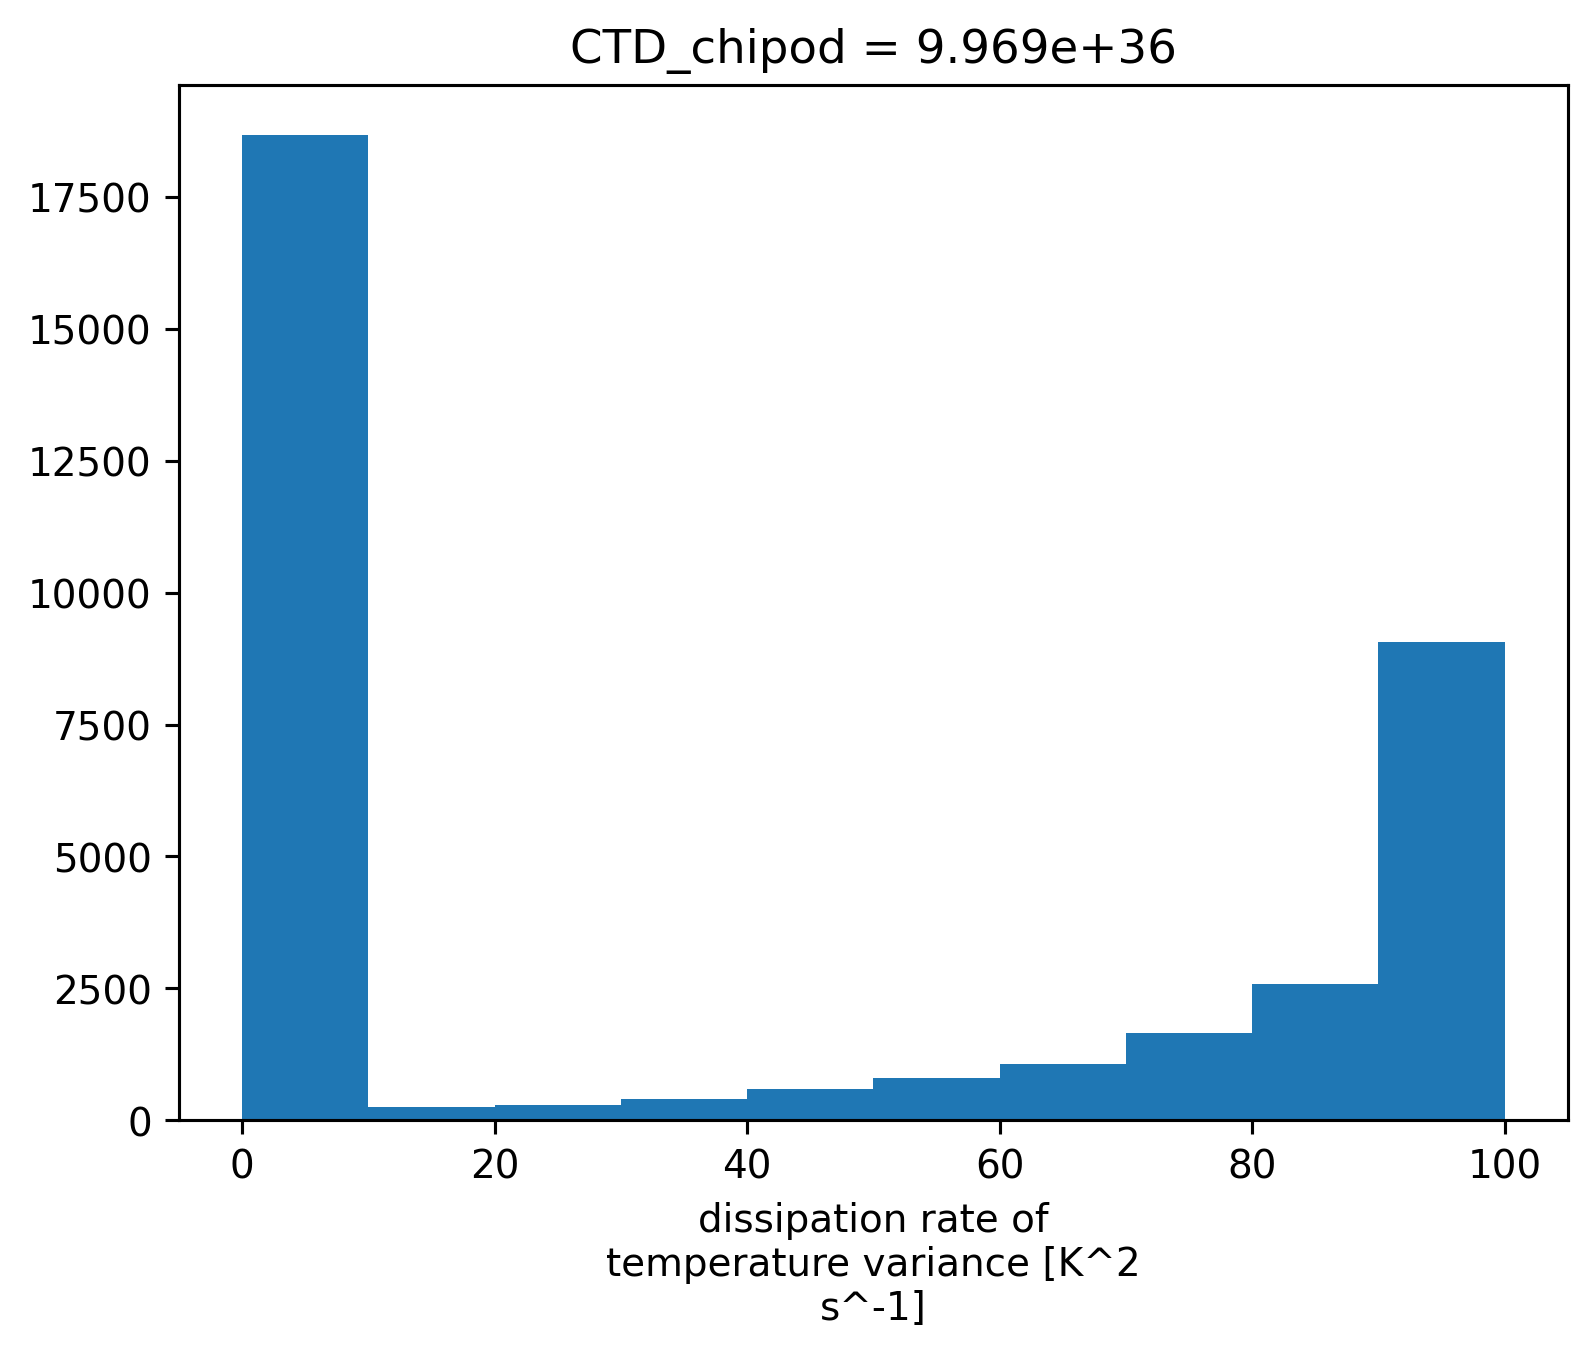

In [8]:
ctdchi_coarse_counts.chi.plot()

In [9]:
if redo_finescale:
    expocode = ctd.expocode.item()
    finescale = ed.sections.process_finescale_estimate(ctd)
    finescale.to_netcdf(finescalefile)

In [10]:
finescale_ = xr.load_dataset(finescalefile)

finescale = finescale_.rename(
    {  # "pressure": "pressure_fine", "p_bounds": "p_fine_bounds",
        "χ": "chi",
        "ε": "eps",
        "Kρ": "Krho",
        "Tzlin": "Tz",
        "N2mean": "N2",
    }
)
mask = finescale.p_bounds.isel(nbnds=1) < ctd.cf["sea_floor_depth_below_sea_surface"]
# finescale = finescale.rename_vars({var: f"{var}_fine" for var in finescale})
for var in finescale:
    finescale[var] = finescale[var].where(mask)
    finescale[var].attrs["description"] = "estimated using finescale method"
# finescale["pressure_fine"].attrs["bounds"] = "p_fine_bounds"
finescale

<xarray.Dataset>
Dimensions:             (pressure: 65, criteria: 4, station: 145, nbnds: 2)
Coordinates: (12/18)
  * pressure            (pressure) float64 200.0 300.0 ... 6.499e+03 6.549e+03
  * criteria            (criteria) object 'mixsea' 'kunze' 'whalen' 'whalen_7'
  * station             (station) int64 1 2 3 4 5 6 ... 140 141 142 143 144 145
    flag                (station, pressure) float64 5.0 5.0 5.0 ... 5.0 5.0 1.0
    npts                (station, pressure) float64 99.0 99.0 99.0 ... 98.0 48.0
    γmean               (station, pressure) float64 25.55 26.26 ... nan nan
    ...                  ...
    longitude           (station) float64 -78.67 -80.0 -79.97 ... -13.41 -13.37
    time                (station) datetime64[ns] 2015-12-09T21:48:00 ... 2016...
    expocode            object '74EQ20151206'
    cast                int8 1
    section_id          object 'A05'
    sample              (station, pressure) object '' '' '' '' ... '' '' '' ''
Dimensions without coordinates: nbnds
Data variables: (12/14)
    eps                 (station, pressure, criteria) float64 6.09e-09 ... nan
    Krho                (station, pressure, criteria) float64 1.261e-05 ... nan
    ξvar                (station, pressure, criteria) float64 0.2181 ... nan
    ξvargm              (station, pressure, criteria) float64 0.1389 ... nan
    Tz                  (station, pressure) float64 0.0371 0.01715 ... nan nan
    Tzmean              (station, pressure) float64 0.03458 0.01923 ... nan nan
    ...                  ...
    Tmode               (station, pressure) float64 85.0 85.0 85.0 ... nan nan
    σmode               (station, pressure) float64 85.0 85.0 85.0 ... nan nan
    Tmld                (station, pressure) float64 83.0 83.0 83.0 ... nan nan
    σmld                (station, pressure) float64 25.0 25.0 25.0 ... nan nan
    chi                 (station, pressure, criteria) float64 3.016e-08 ... nan
    KtTz                (station, pressure, criteria) float64 4.361e-07 ... nan

In [11]:
(profilevar,) = ctd.cf.cf_roles["profile_id"]
profilevar

'station'

## Merge all datasets

In [12]:
import datatree
from cf_xarray.accessor import CFAccessor, CFDatasetAccessor


@datatree.register_datatree_accessor("cf")
class CFDataTreeAccessor:
    def __init__(self, obj):
        self._obj = obj
        self._dsaccess = CFDatasetAccessor(obj.ds)

    def __getattr__(self, name):
        return getattr(self._dsaccess, name)

    def __getitem__(self, key):
        return self._dsaccess[key]


merged = datatree.DataTree.from_dict(
    {
        "ctd": ctd,
        "chipod": ctdchi,
        "finescale": finescale,
        "chipod_coarse": ctdchi_coarse,
    }
)
ed.sections.add_ancillary_variables(merged)

In [13]:
# merged["chipod"].ds = dcpy.oceans.thorpesort(
#    merged["chipod"].ds, by="gamma_n", core_dim="pressure"
# )

In [14]:
merged.to_netcdf(mergedfile)

## Summaries

In [15]:
section = merged  # datatree.open_datatree(mergedfile)

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    micromeans = (
        section["chipod_coarse"]
        .ds.groupby_bins("station", bins=station_bin_edges)
        .mean()
    )
    finemeans = (
        section["finescale"].ds.groupby_bins("station", bins=station_bin_edges).mean()
    )

### Section Map

### Micro vs Fine

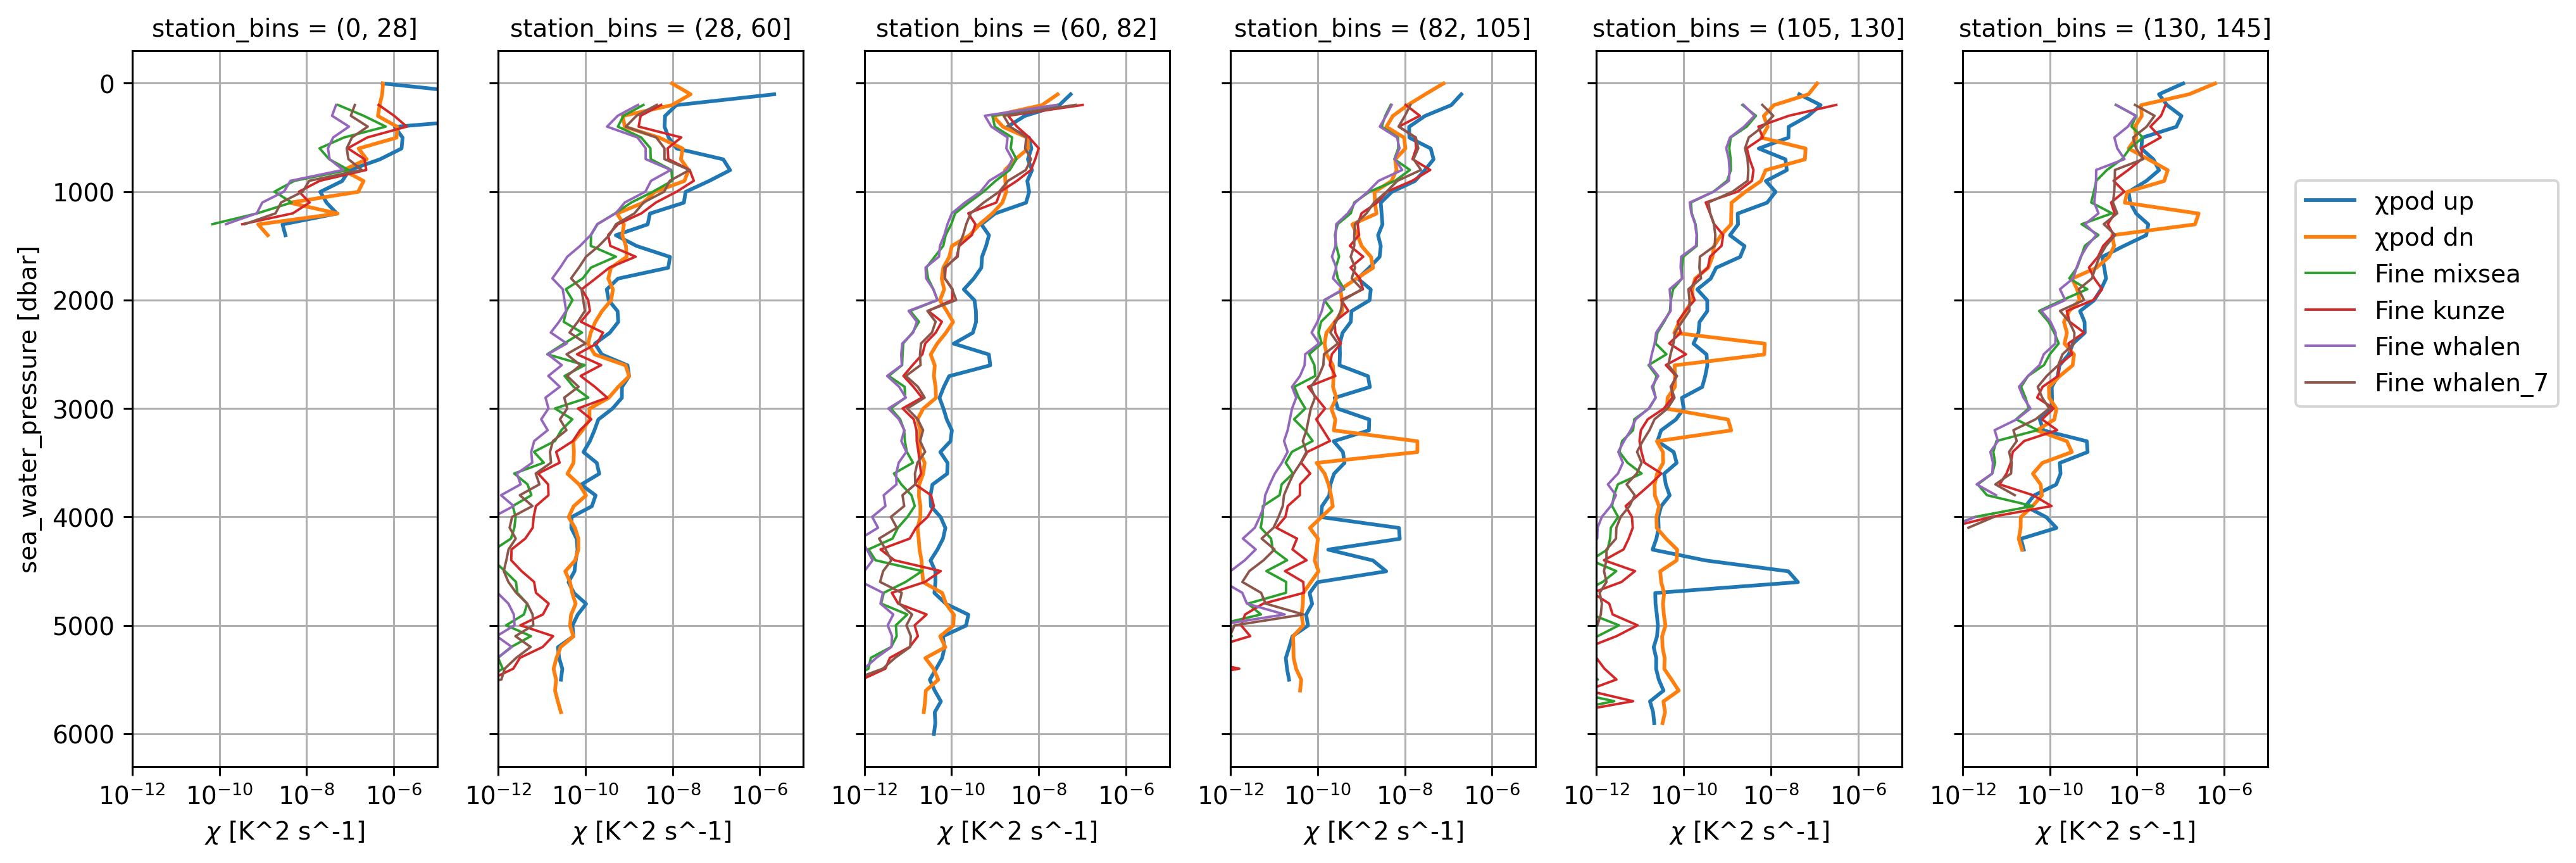

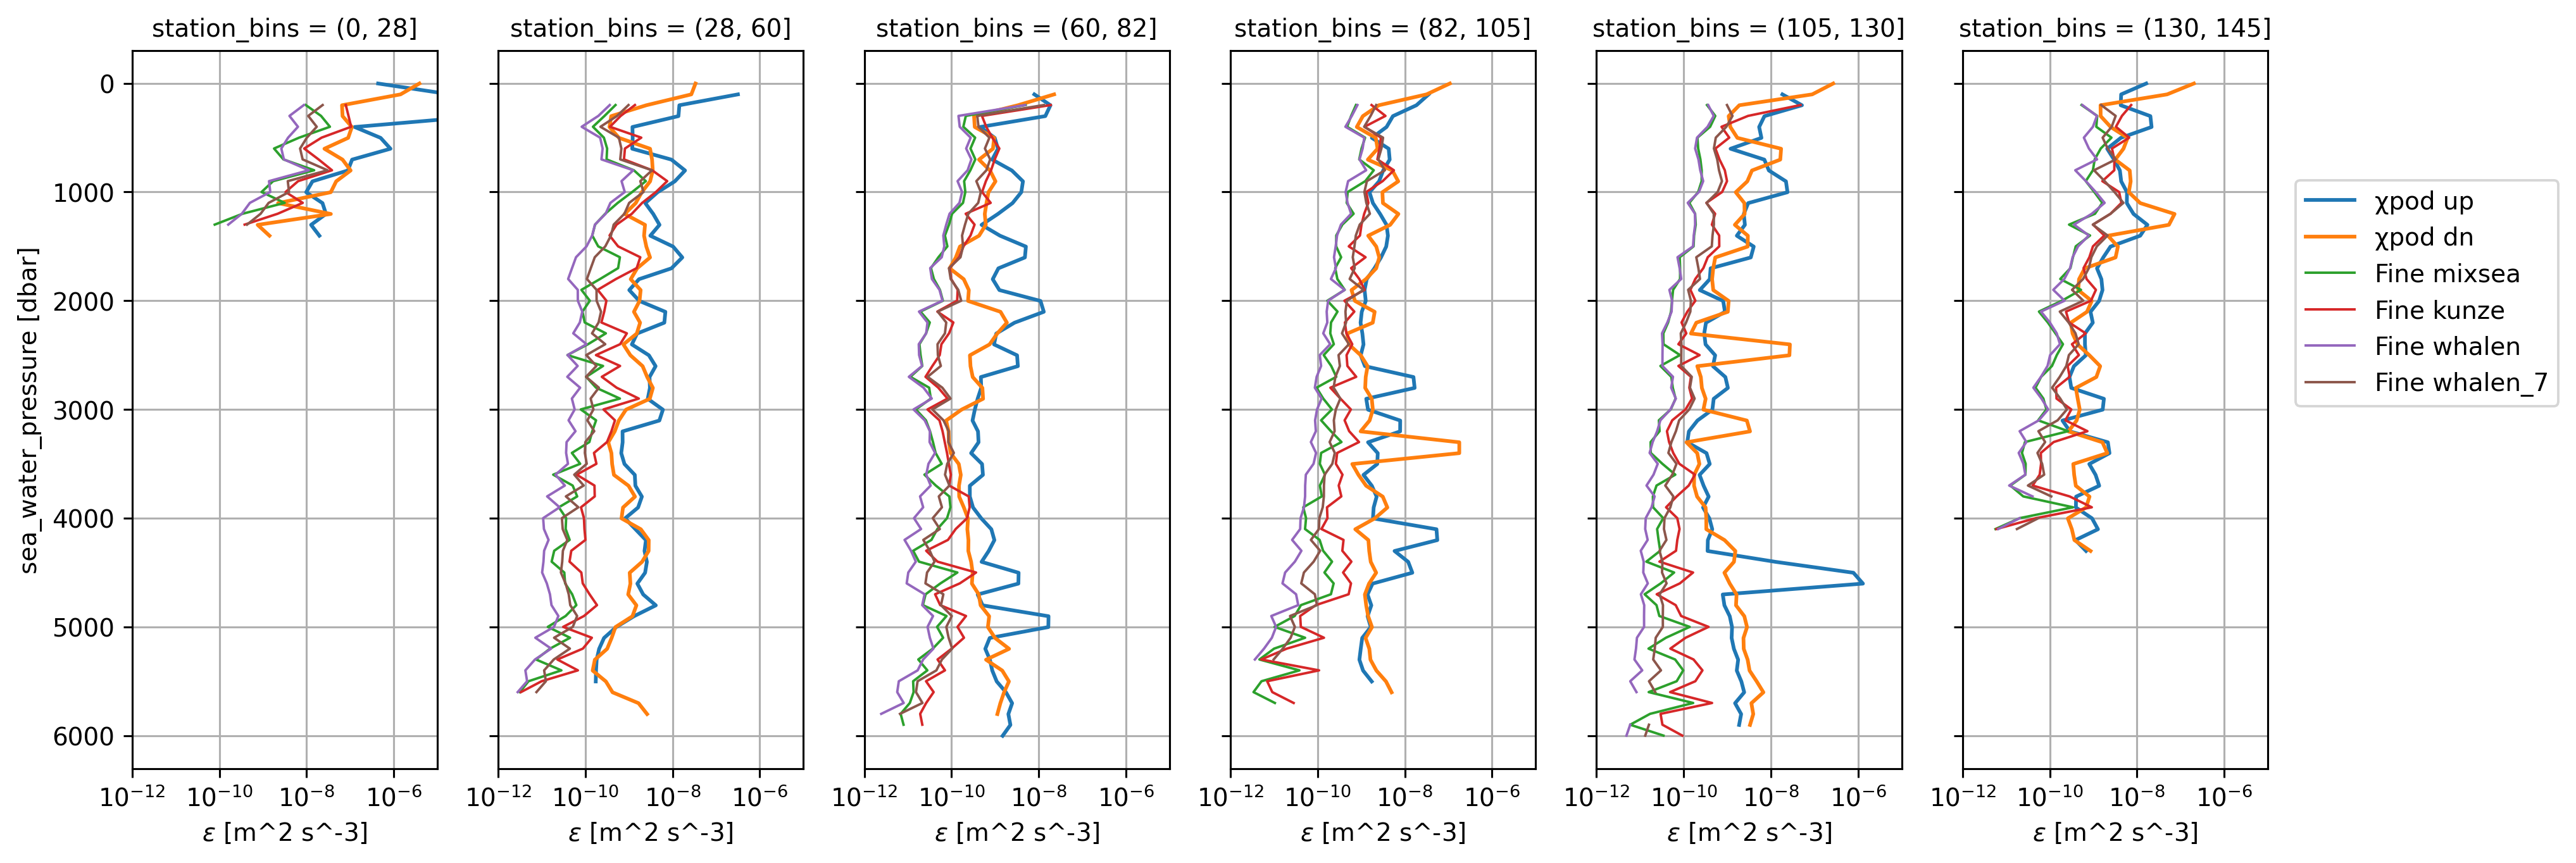

In [17]:
def compare_micro_fine_section(var, micromeans, finemeans):
    micromeans[var].attrs["long_name"] = finemeans[var].attrs["long_name"]

    fg = micromeans.sel(cleaner="none")[var].cf.plot(
        y="pressure",
        col="station_bins",
        hue="direction",
        xscale="log",
        aspect=0.4,
        size=5,
        add_legend=False,
        xlim=(1e-12, 1e-5),
    )
    #    for idx, (name, ax) in enumerate(zip(fg.name_dicts.ravel(), fg.axs.ravel())):
    #        hdl = (
    #            micromeans[var]
    #            .sel(cleaner="GE")
    #            .sel(name)
    #            .cf.plot.line(
    #                y="pressure",
    #                hue="direction",
    #                add_legend=False,
    #                ax=ax,
    #                _labels=False,
    #                lw=0.5,
    #            )
    #        )
    #        fg._mappables[idx].extend(hdl)

    for idx, (name, ax) in enumerate(zip(fg.name_dicts.ravel(), fg.axs.ravel())):
        hdl = (
            finemeans[var]
            .sel(name)
            .cf.plot.line(
                y="pressure",
                hue="criteria",
                add_legend=False,
                ax=ax,
                _labels=False,
                lw=1,
            )
        )
        fg._mappables[idx].extend(hdl)
        ax.grid(True, which="both")

    fg.fig.legend(
        handles=fg._mappables[-1],
        labels=[f"χpod {direction}" for direction in micromeans.direction.data]
        # + [f"χpod GE {direction}" for direction in micromeans.direction.data]
        + [f"Fine {criteria}" for criteria in finemeans.criteria.data],
        bbox_to_anchor=(1.12, 0.8),
    )
    return fg


compare_micro_fine_section("chi", micromeans, finemeans)
compare_micro_fine_section("eps", micromeans, finemeans)

## Microstructure data

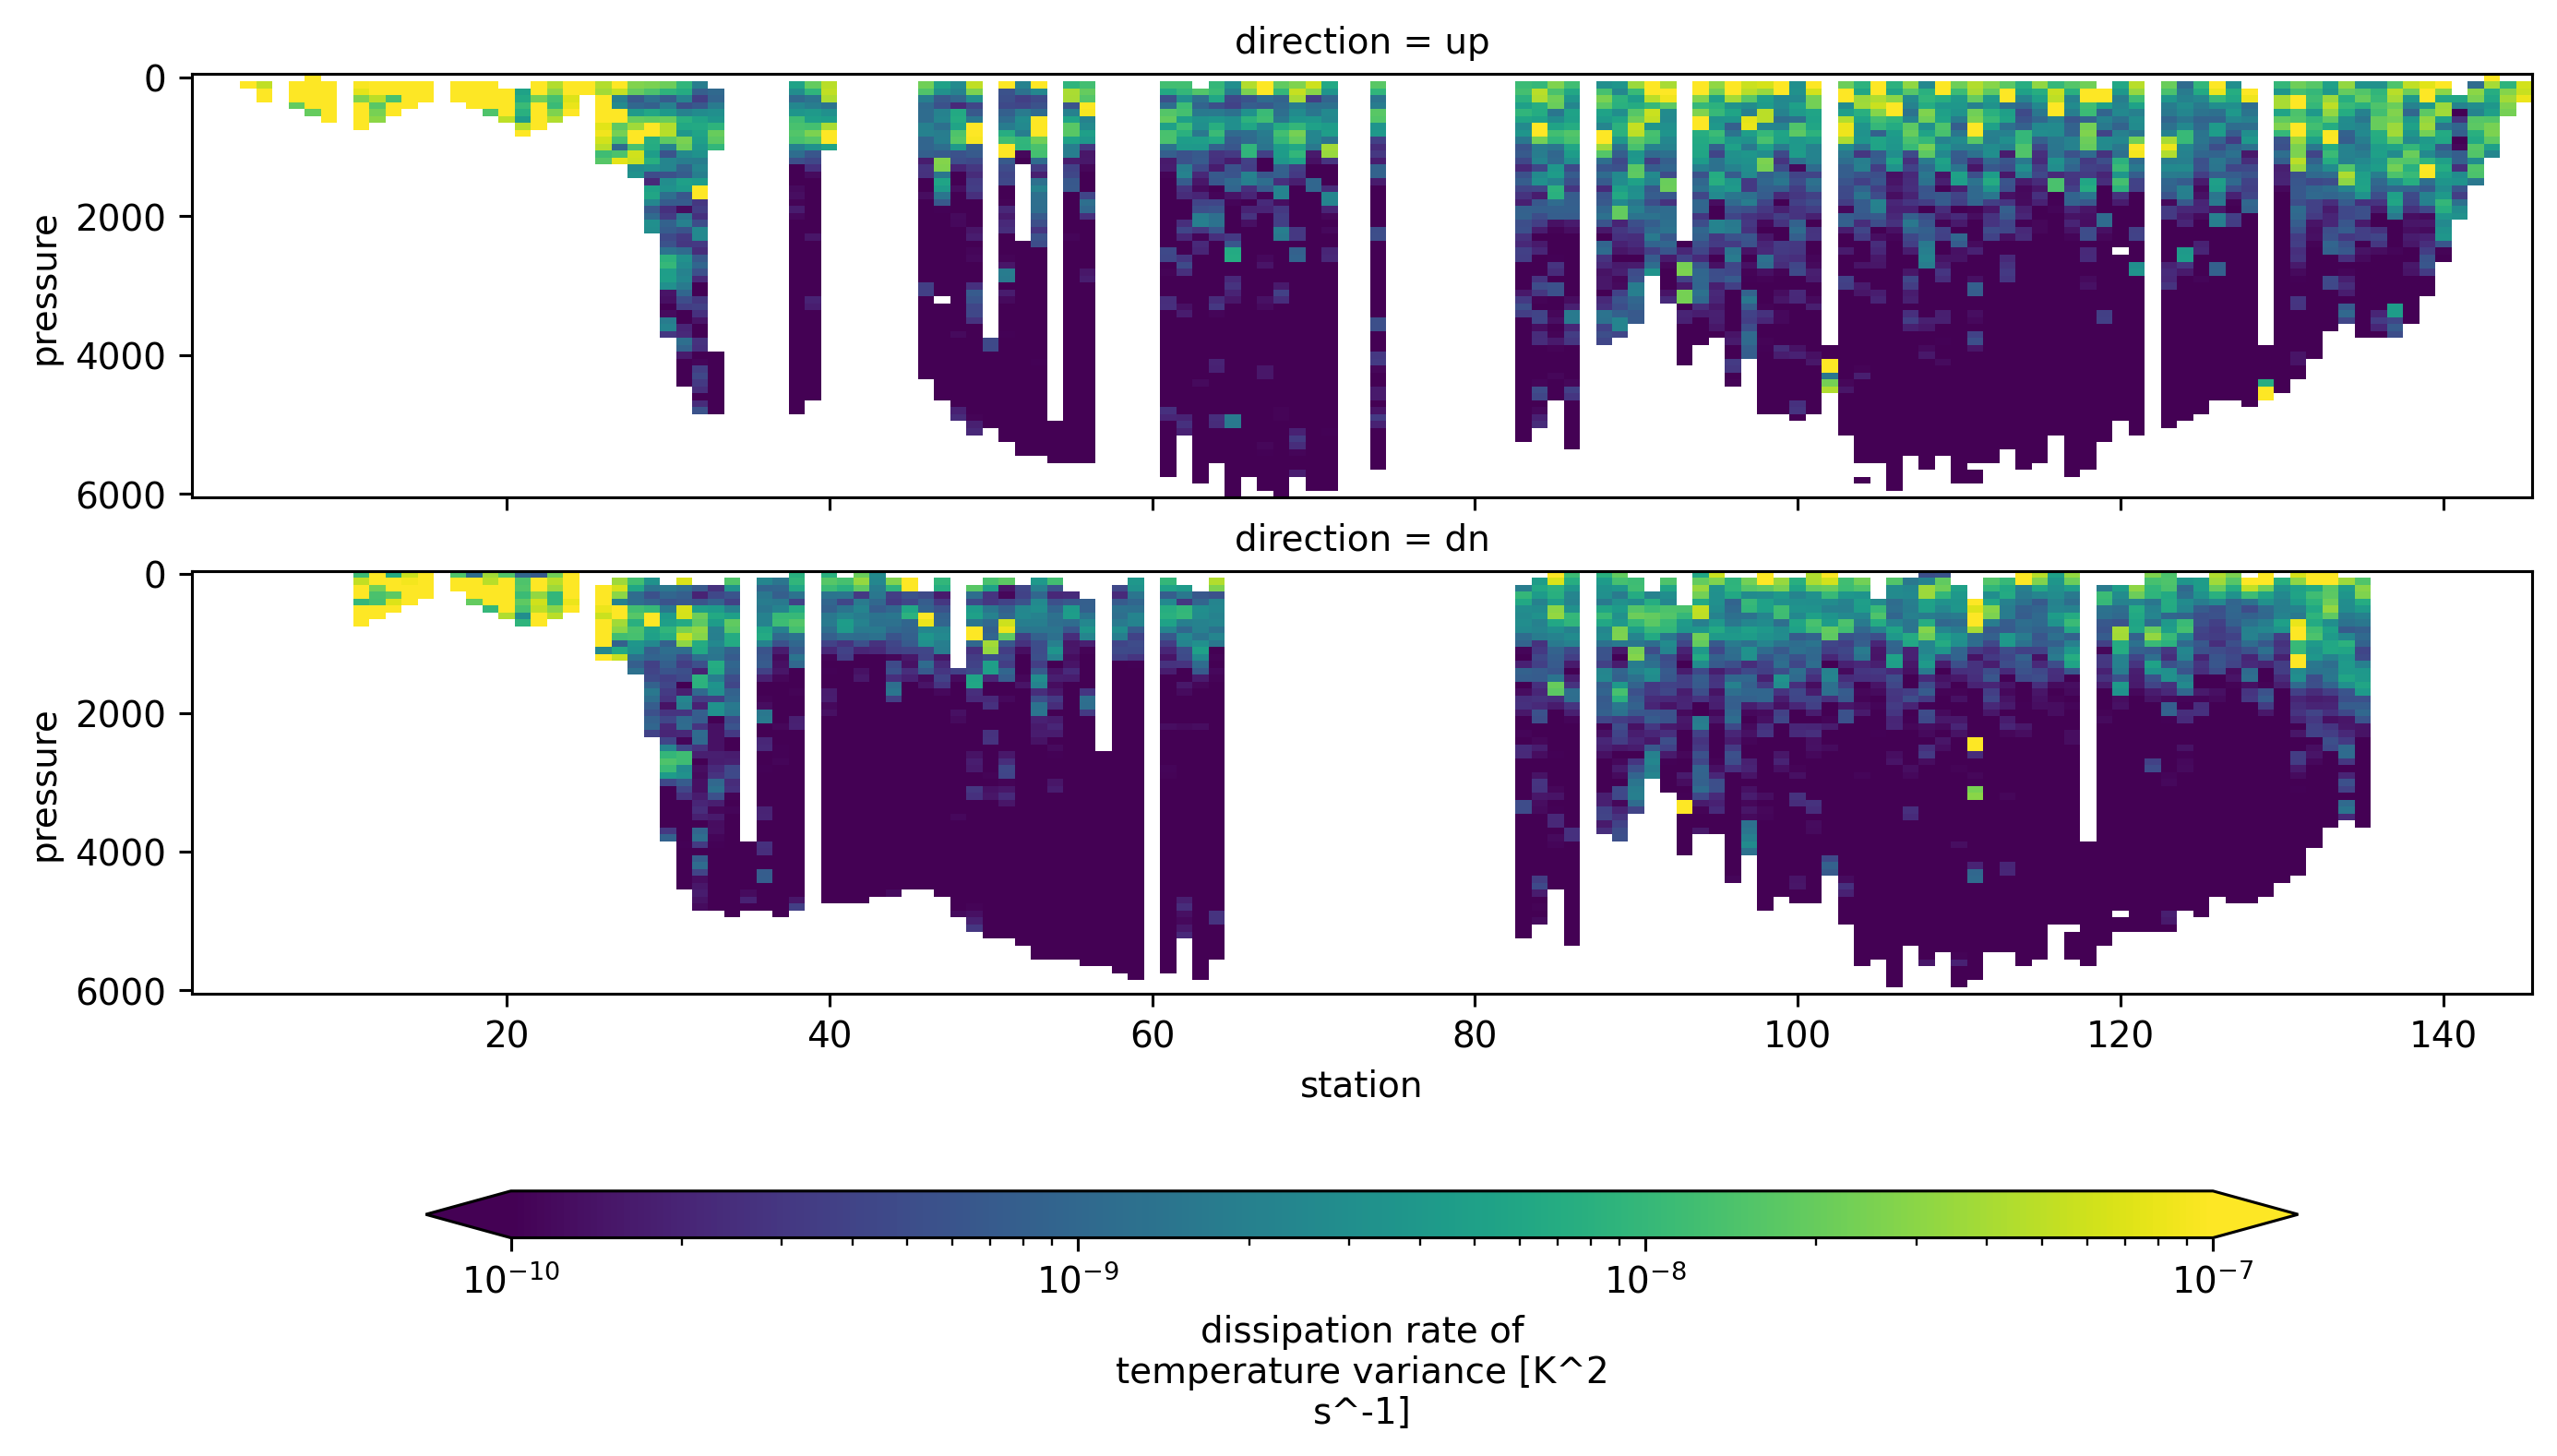

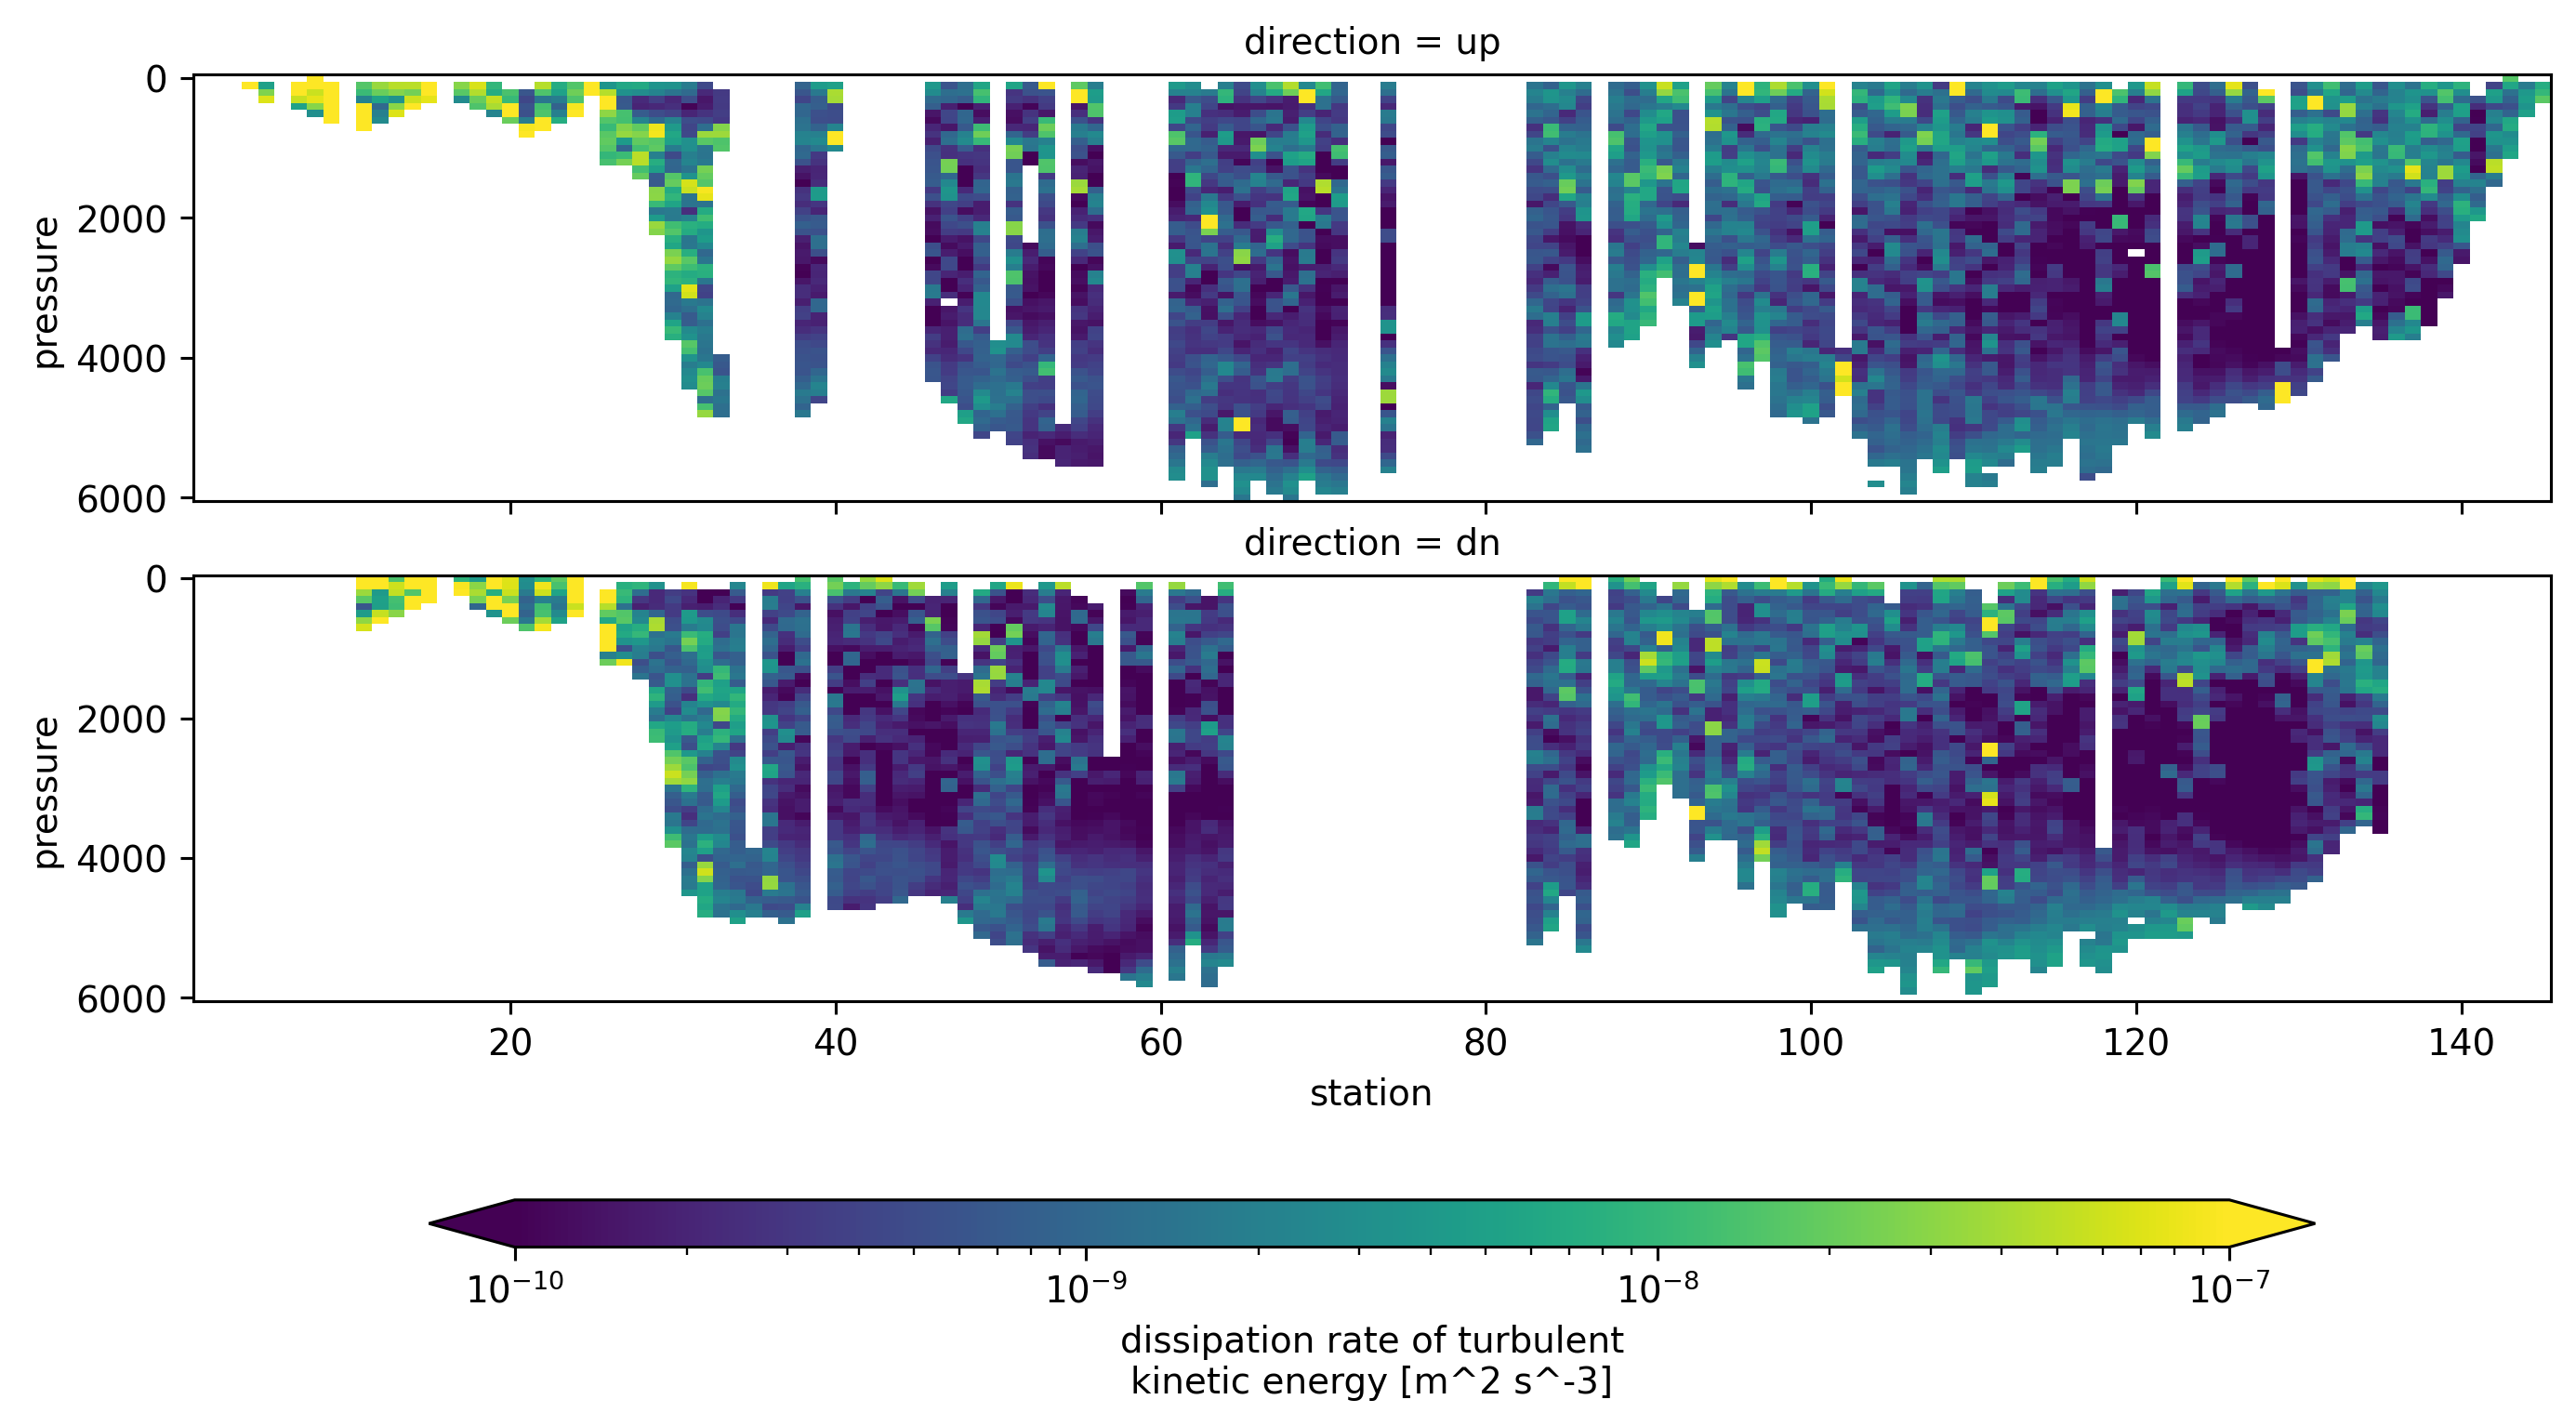

In [18]:
section["chipod_coarse"].ds.chi.sel(cleaner="none").cf.plot(
    row="direction", **section_kwargs, **kwargs["chi"]
)
section["chipod_coarse"].ds.eps.sel(cleaner="none").cf.plot(
    row="direction", **section_kwargs, **kwargs["eps"]
)

## Finescale parameterization

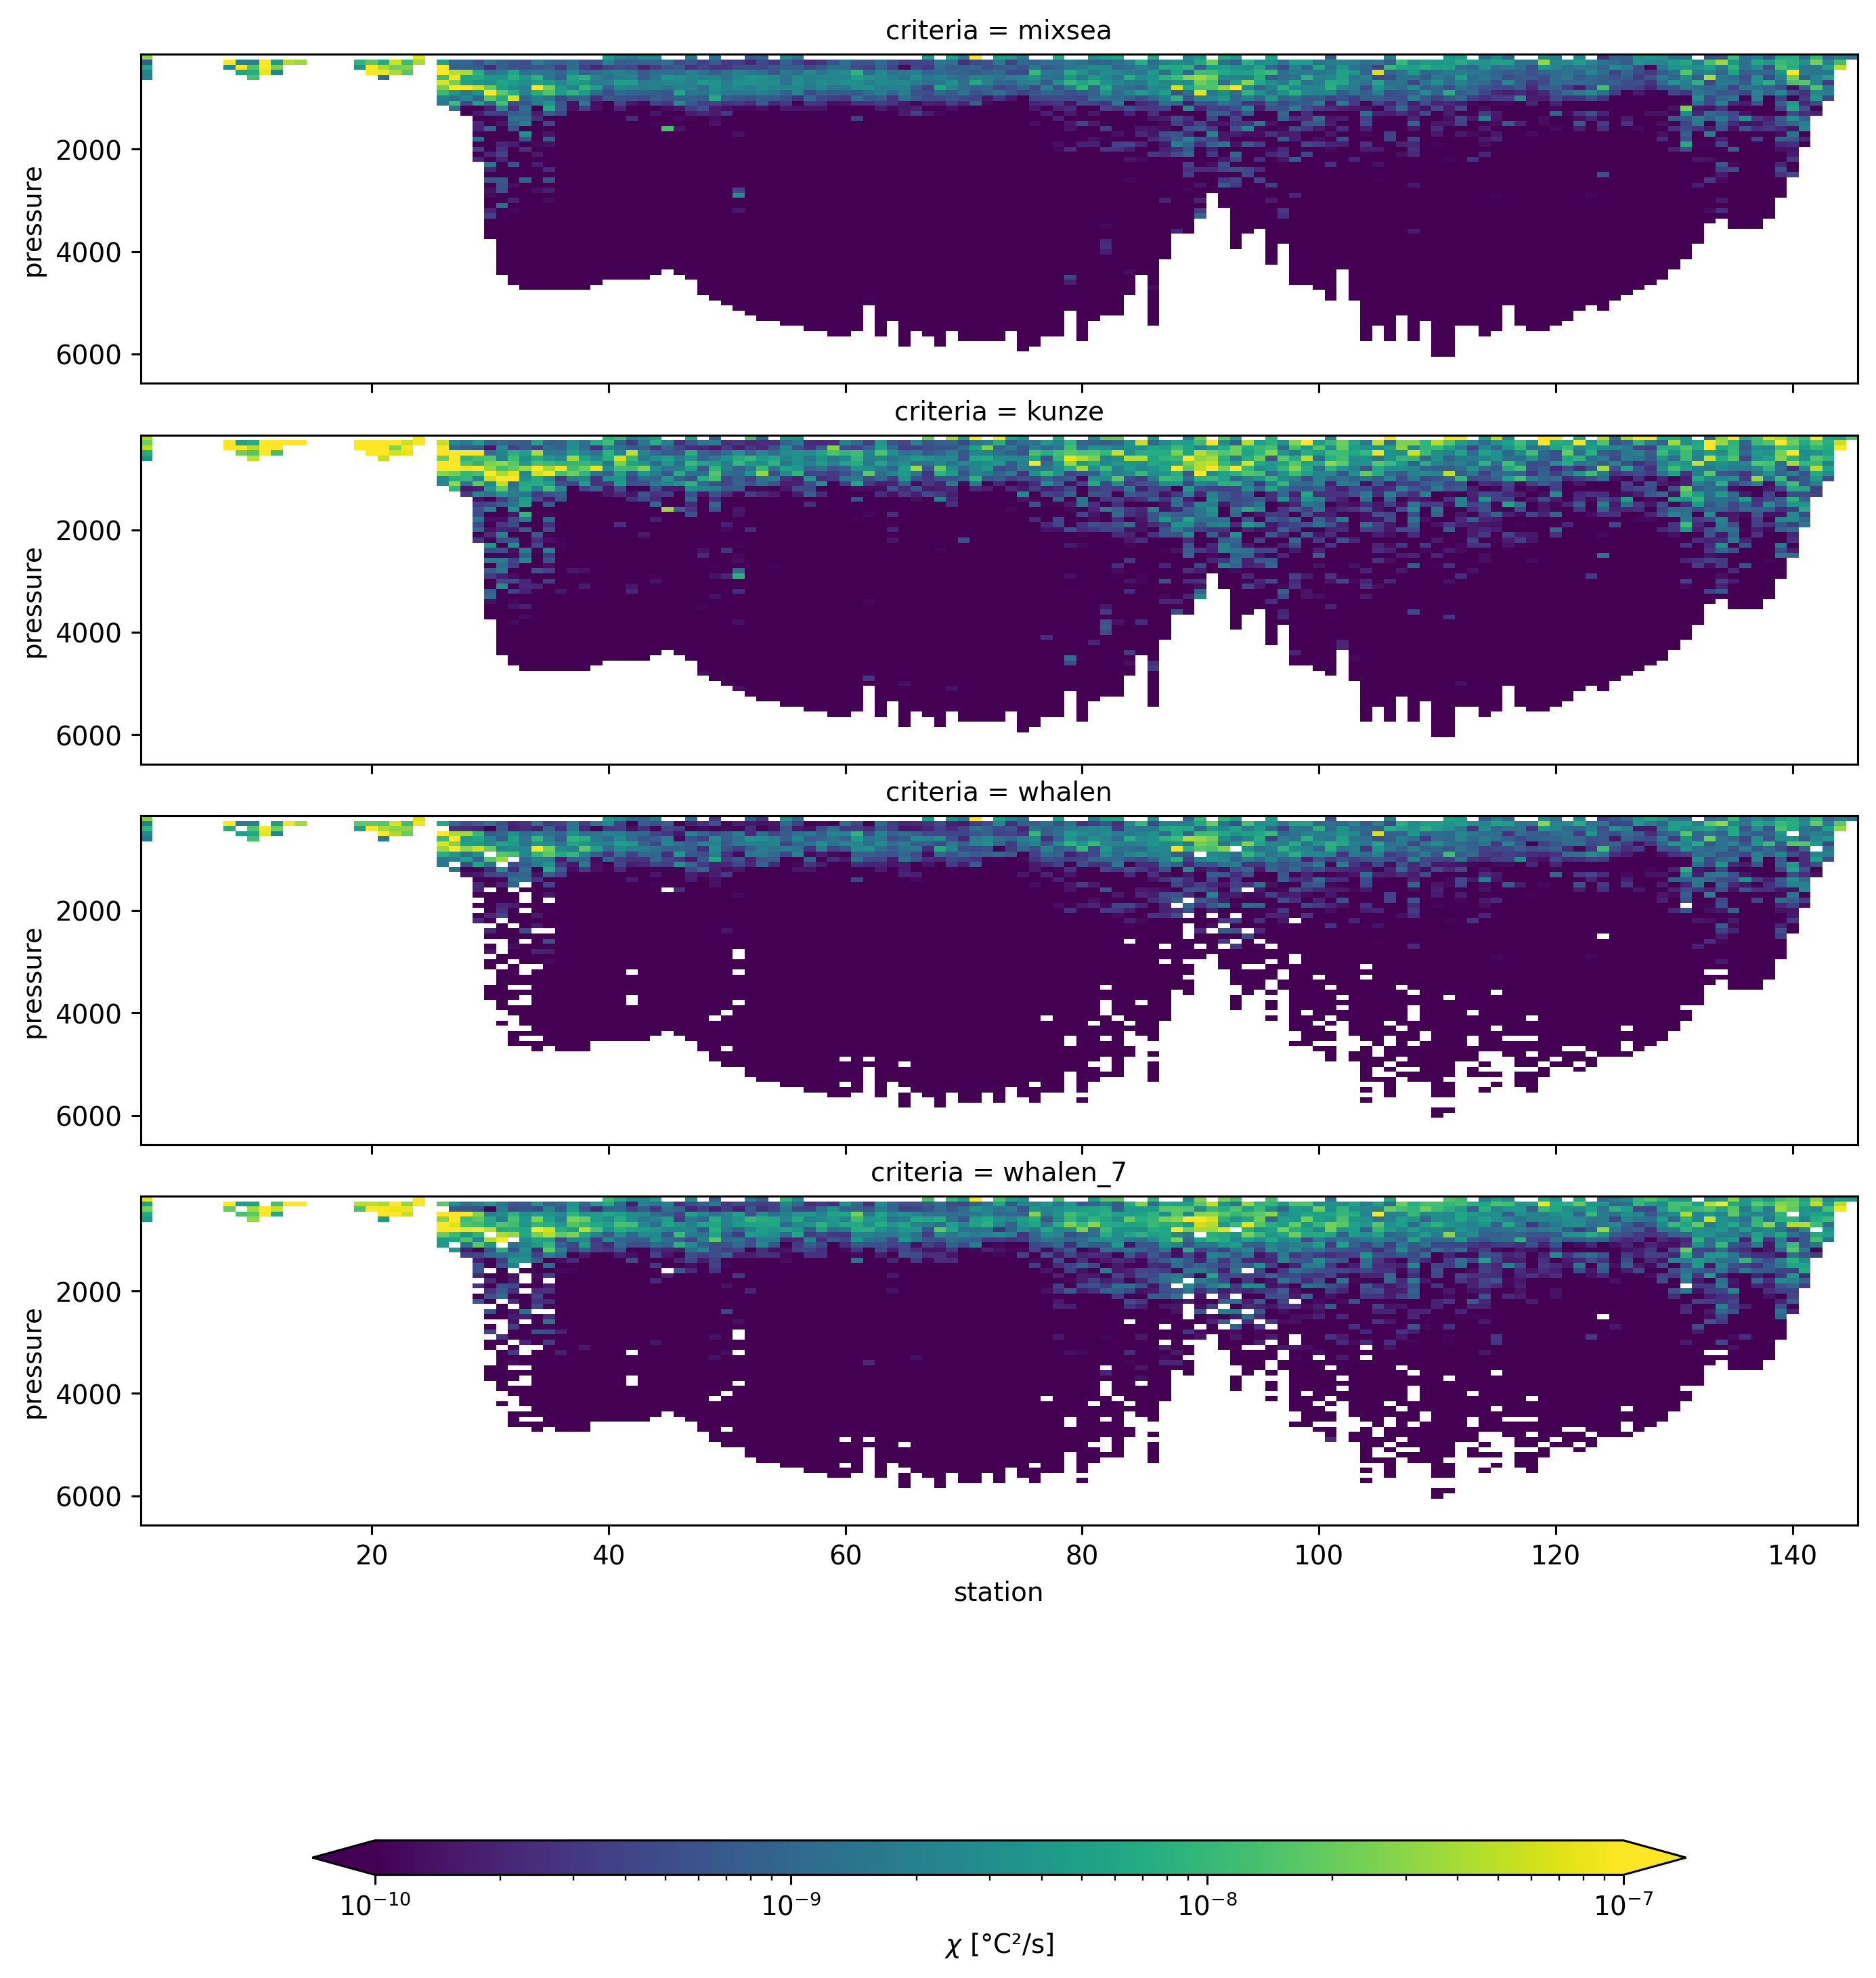

In [19]:
section["finescale"].ds.chi.cf.plot(row="criteria", **section_kwargs, **kwargs["chi"])

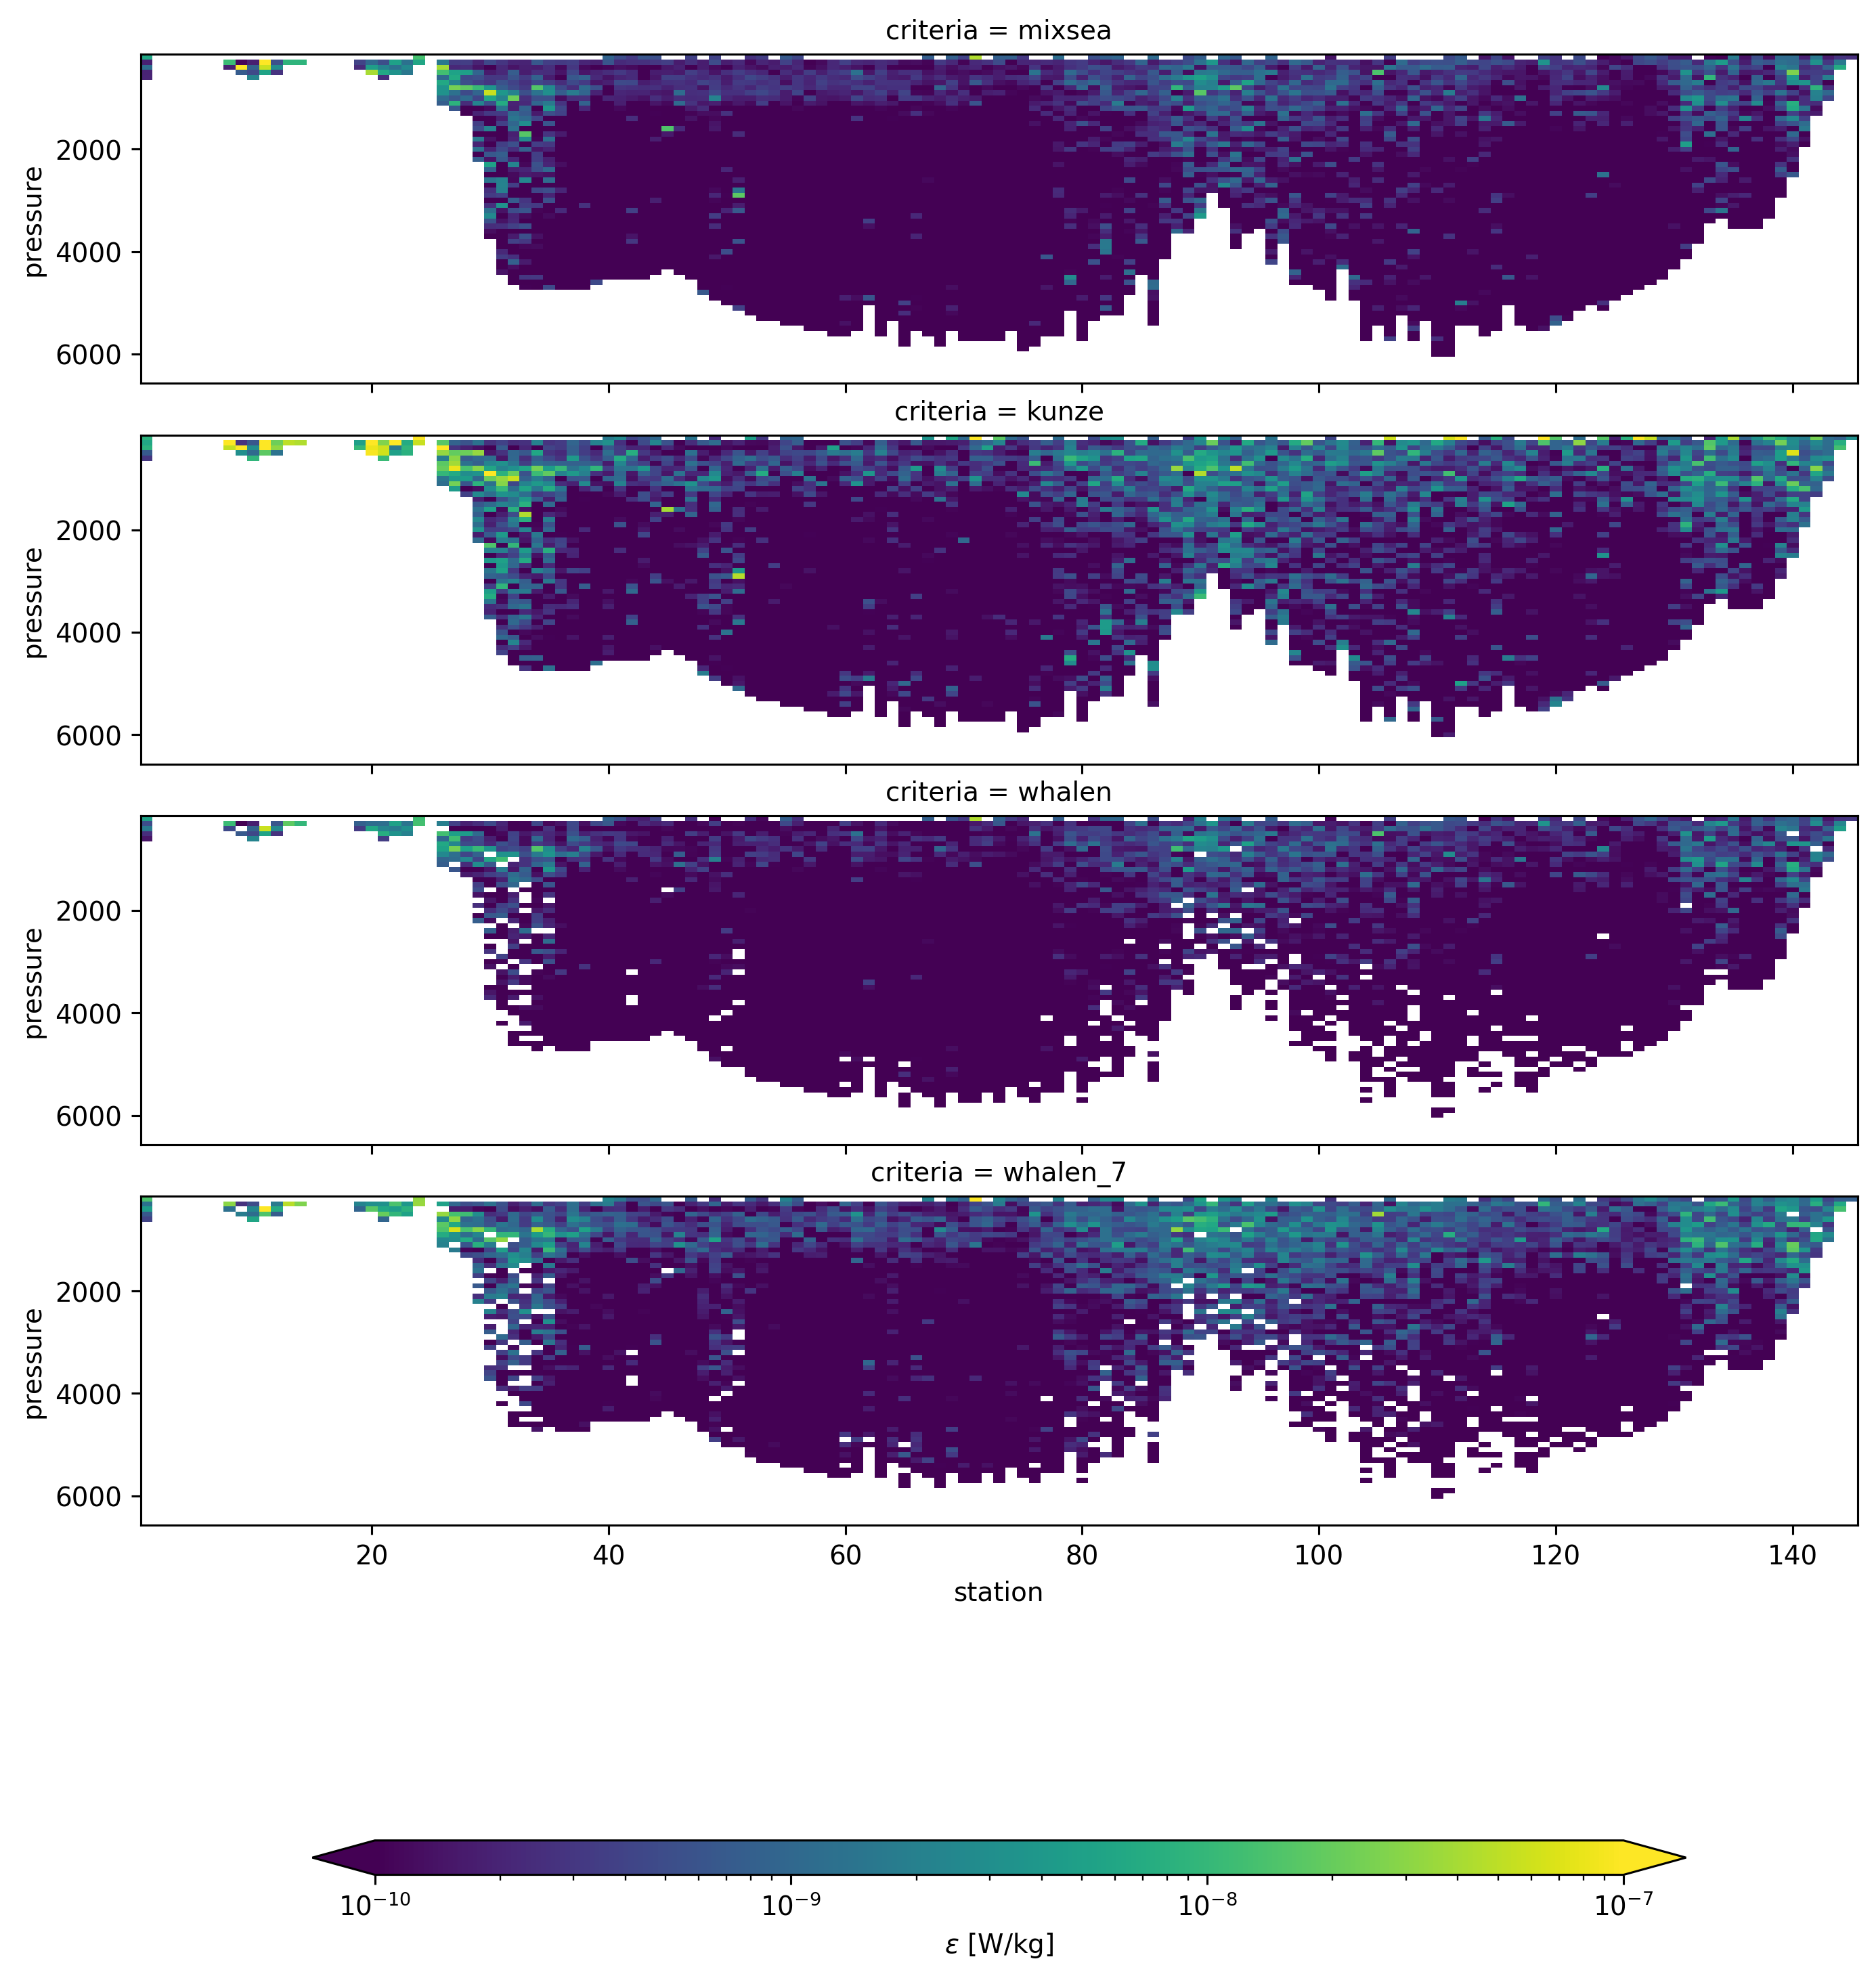

In [20]:
section["finescale"].ds.eps.cf.plot(row="criteria", **section_kwargs, **kwargs["eps"])

### T-S plot